In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np    # linear algebra
import pandas as pd   # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

References:
- [elastropy's playlist on Physics Informed Neural Networks](https://youtube.com/playlist?list=PLM7DTyYjZGuLmg3f6j40fEF18jyQmYsC2&si=35a-jywar0nasELh)


This notebook continues from the previous 2 notebooks on basic PINNs:
- [basic-pinn-1](https://www.kaggle.com/code/aryamanbansal/basic-pinn-1/edit)
- [basic-pinn-2](https://www.kaggle.com/code/aryamanbansal/basic-pinn-2/edit)

# Physics Informed Neural Networks (PINNs)

## Problem Definition - Newton's Law of Cooling

Let's consider Newton's law of cooling, which describes the rate of change of temperature of an object in a surrounding medium. The law states that the rate of change of temperature is proportional to the difference between the object's temperature and the ambient temperature (temperature of the surrounding medium).

The mathematical formulation is given by:
$$\frac{dT}{dt} + k(T_a - T) = 0 $$
where:
- $T$ is the temperature of the object,
- $T_a$ is the ambient temperature,
- $k$ is a positive constant that depends on the properties of the object and the medium.

Initial conditions and constants:
- $T(t=0) = T_0 = 250 \degree C$
- $T_a = 27 \degree C$ 
- $k = 0.45 \text{ sec}^{-1}$

Analytical solution:

$$T(t) = T_a + (T_0 - T_a) e^{-kt}$$

## Loss functions

There are three main components to the loss function in a PINN:

#### 1. Data Loss
This term measures the difference between the predicted solution and the true solution at given data points. For example, if we have a set of data points $(t_i, T_i)$, the data loss can be defined as:
$$\text{Data Loss} = \mathcal{L}_{data} = \frac{1}{N} \sum_{i=1}^{N} (\hat{T}(t_i) - T_i)^2$$

where $N$ is the number of data points.

#### 2. ODE Loss
This term measures how well the neural network satisfies the differential equation. It is computed by evaluating the neural network at a set of collocation points and calculating the residual of the ODE. For our example, the ODE loss can be defined as:

\begin{align*}
\text{ODE Loss} = \mathcal{L}_{ODE} &= \frac{1}{M} \sum_{j=1}^{M} \left( \frac{d\hat{T}}{dt}(t_j) - \frac{dT}{dt}(t_j) \right)^2 \\ \\
&= \frac{1}{M} \sum_{j=1}^{M} \left( \frac{d\hat{T}}{dt}(t_j) + k(T_a - T(t_j)) \right)^2 \quad \left( \because \frac{dT}{dt}(t_j) = - k(T_a - T(t_j)) \right) \\
\end{align*}

<!-- &= \frac{1}{M} \sum_{j=1}^{M} \left( \frac{d\hat{T}}{dt}(t_j) + k(T_a - T_a - (T_0 - T_a) e^{-kt_j}) \right)^2 \quad \left( \because T(t) = T_a + (T_0 - T_a) e^{-kt} \right) \\
&= \frac{1}{M} \sum_{j=1}^{M} \left( \frac{d\hat{T}}{dt}(t_j) - k(T_0 - T_a) e^{-kt_j}) \right)^2 \\ -->


#### 3. Initial condition Loss
This term ensures that the neural network satisfies the initial condition. For our example, the initial condition loss can be defined as:

\begin{align*}
\text{Initial Condition Loss} = \mathcal{L}_{initial} &= \left(T(0) - \hat{T}(0)\right)^2 \\
&= \left(T_0 - \hat{T}(0)\right)^2 \\
\end{align*}

#### 4. Total Loss
The total loss function is a weighted sum of the three components:

$$\mathcal{L}_{total} = \lambda_1 \cdot \mathcal{L}_{data} + \lambda_2 \cdot \mathcal{L}_{ODE} + \lambda_3 \cdot \mathcal{L}_{initial}$$

$$\text{OR}$$

$$\text{Total Loss} = \lambda_1 \cdot \text{Data Loss} + \lambda_2 \cdot \text{ODE Loss} + \lambda_3 \cdot \text{Initial Condition Loss}$$

where $\lambda_1$, $\lambda_2$, and $\lambda_3$ are hyperparameters that control the relative importance of each term.

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

# from scipy.integrate import solve_bvp
from tqdm import tqdm
import gc

# plot settings
plt.close("all")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 10
plt.rcParams["figure.dpi"] = 100

print("imports done!")

imports done!


In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [44]:
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, output_dim),
        )
    
    def forward(self, x):
        return self.model(x)


print("physics-informed neural network created!")

physics-informed neural network created!


In [45]:
# Automatic differentiation
def derivative(T, t):
    """
    Computes dT/dt using PyTorch's autograd.
    T and t must be tensors with requires_grad=True for t.
    """
    return torch.autograd.grad(
        T, t,
        grad_outputs=torch.ones_like(T),
        create_graph=True
    )[0]


print("automatic differentiation function created!")

automatic differentiation function created!


In [46]:
def loss_function(model, t, T, t_ic, T_ic, lambda_data, lambda_ode, lambda_ic, T_0=250, T_a=27, k=0.45):
    # make a fresh copy of t that requires grads
    # we must do this before passing x through the model
    # otherwise the forward-graph will already be built
    t_coll = t.clone().detach().requires_grad_(True)
    
    # Data loss
    T_pred = model(t)
    residual_data = T_pred - T
    data_loss = torch.mean(residual_data.pow(2))

    # ODE loss
    T_coll = model(t_coll)
    T_t = derivative(T_coll, t_coll)   # dT/dt
    # ode_loss = torch.mean((T_t - (k*(T_0 - T_a))**torch.exp(-k*t_coll))**2)
    residual_ode = T_t + k * (T_coll - T_a)
    ode_loss = torch.mean(residual_ode.pow(2))

    # Initial condition loss
    T_ic_pred = model(t_ic)
    residual_ic = T_ic_pred - T_ic
    initial_loss = torch.mean(residual_ic.pow(2))

    return lambda_data*data_loss + lambda_ode*ode_loss + lambda_ic*initial_loss


print("loss function created!")

loss function created!


In [47]:
def train(model, t_data, T_data, t_ic, T_ic, lambda_data, lambda_ode, lambda_ic,
          epochs=10000, learning_rate=0.001, device="cpu", T_0=250, T_a=27, k=0.45):
    model = model.to(device)
    t_data = t_data.to(device)
    T_data = T_data.to(device)
    t_ic = t_ic.to(device)
    T_ic = T_ic.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()
        loss = loss_function(model, t_data, T_data, t_ic, T_ic, lambda_data, lambda_ode, lambda_ic, T_0, T_a, k)
        loss.backward()
        optimizer.step()
        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    return model


print("training function created!")

training function created!


In [48]:
# Generate training data
def generate_data(t_min=-20.0, t_max=40.0, T_a=27.0, t_0=0.0, T_0=250.0, k=0.45, num_points=1000):
    T_a = torch.tensor([T_a])
    T_0 = torch.tensor([T_0])
    k = torch.tensor([k])
    # generate evenly spaced points from the domain [t_min, t_max]
    t_data = torch.linspace(t_min, t_max, num_points).view(-1, 1)    # collocation points
    T_data = T_a + (T_0 - T_a)*torch.exp(-k*t_data)
    t_ic = torch.tensor([t_0])
    T_ic = torch.tensor([T_0])
    return t_data, T_data, t_ic, T_ic


print("data generation functions created!")

data generation functions created!


In [49]:
# Hyperparameters
input_dim = 1
output_dim = 1
hidden_units = 50
epochs = 15000
learning_rate = 0.001
lambda_data = 0.0
lambda_ode = 1.0
lambda_bc = 1.0

# Generate training data and collocation points
x_data, y_data, x_bc, y_bc = generate_data()

# Initialize the PINN model
model = PINN(input_dim, hidden_units, output_dim)

# Train the model
trained_model = train(model, x_data, y_data, x_bc, y_bc, lambda_data, lambda_ode, lambda_bc, epochs, learning_rate, device)


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 0, Loss: 62713.125


  7%|▋         | 1022/15000 [00:07<01:41, 137.61it/s]

Epoch 1000, Loss: 38674.5078125


 13%|█▎        | 2022/15000 [00:15<01:33, 139.45it/s]

Epoch 2000, Loss: 23468.3984375


 20%|██        | 3022/15000 [00:23<01:29, 134.20it/s]

Epoch 3000, Loss: 13046.61328125


 27%|██▋       | 4012/15000 [00:30<01:34, 115.75it/s]

Epoch 4000, Loss: 6401.27587890625


 33%|███▎      | 5020/15000 [00:38<01:12, 137.94it/s]

Epoch 5000, Loss: 2580.70166015625


 40%|████      | 6026/15000 [00:47<01:11, 124.70it/s]

Epoch 6000, Loss: 678.0308837890625


 47%|████▋     | 7020/15000 [00:54<00:59, 133.56it/s]

Epoch 7000, Loss: 146.3635711669922


 53%|█████▎    | 8016/15000 [01:02<01:00, 114.74it/s]

Epoch 8000, Loss: 61.063148498535156


 60%|██████    | 9015/15000 [01:10<00:47, 126.16it/s]

Epoch 9000, Loss: 45.15454864501953


 67%|██████▋   | 10019/15000 [01:18<00:36, 134.90it/s]

Epoch 10000, Loss: 43.936851501464844


 73%|███████▎  | 11011/15000 [01:25<00:32, 124.39it/s]

Epoch 11000, Loss: 43.774696350097656


 80%|████████  | 12014/15000 [01:34<00:23, 128.77it/s]

Epoch 12000, Loss: 43.68254470825195


 87%|████████▋ | 13022/15000 [01:42<00:15, 129.90it/s]

Epoch 13000, Loss: 43.626792907714844


 93%|█████████▎| 14013/15000 [01:50<00:08, 120.47it/s]

Epoch 14000, Loss: 43.565704345703125


100%|██████████| 15000/15000 [01:57<00:00, 127.23it/s]


In [50]:
gc.collect()
print("freed up some memory")

freed up some memory


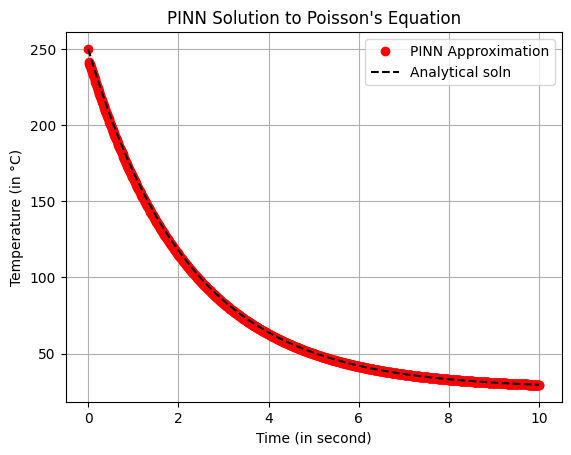

In [55]:
# Plot the results
T_0=250
T_a=27
k=0.45
x_plot = torch.linspace(0, 10, 1000, device=device).view(-1, 1)
y_plot = trained_model(x_plot).cpu().detach().numpy()
analytical_soln = T_a + (T_0 - T_a)*np.exp(-k * x_plot).cpu().detach().numpy()

plt.plot(x_plot.cpu().numpy(), y_plot, 'ro', label='PINN Approximation')
plt.plot(x_plot.cpu().numpy(), analytical_soln, '--', color='black', label="Analytical soln")
plt.title('PINN Solution to Poisson\'s Equation')
plt.xlabel('Time (in second)')
plt.ylabel('Temperature (in °C)')
plt.legend()
plt.grid()
plt.show()